<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Interpretation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the first dataset

We first need to load the dataset. 

In [75]:
import zipfile
import io
import cv2
import glob 
import numpy as np
import random 
import torch 
from google.colab import drive
drive.mount('/content/drive/')

torch.manual_seed(0) # Reproducible, for now 

dtype = torch.float


FIGSIZE = (6,5)



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Now, we need to redefine the model, so that we can compute a saliency map for an input image. Then, we also want to load the state_dict of the trained model. 

In [76]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 4)
    self.pool2 = nn.MaxPool2d(5)
    self.fc1 = nn.Linear(16 * 9 * 11, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 2)
    self.drop = nn.Dropout(p = 0.5)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) # 16*9*11
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net()
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model1.pth'))


<All keys matched successfully>

In [0]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

transforms = transforms.Compose( [ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


images = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/data1", transform = transforms)

idx_to_class = {j:i for i,j in images.class_to_idx.items()}



In [0]:
def display_image(image, true_label, predicted_label = None): 
  plt.figure(figsize = FIGSIZE)
  sample_image = image.numpy().transpose(1,2,0)
  mean = np.array([0.5, 0.5, 0.5])
  sd = np.array([0.5, 0.5, 0.5])
  im = sample_image*sd + mean
  plt.imshow(im)
  title_ = "True label : " + idx_to_class[true_label]
  
  if (predicted_label != None):
    title_ += "/ Predicted : " + idx_to_class[predicted_label]


  plt.title(title_)


In [79]:
!pip install flashtorch

In [0]:

from flashtorch.saliency import Backprop

backprop = Backprop(net)

Let's import an image with label **0**. 

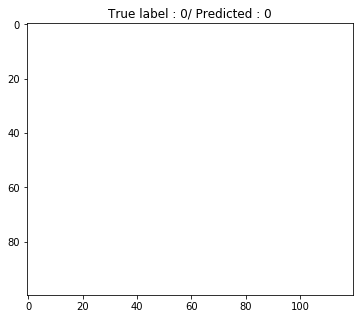

In [81]:
image0 = images[0][0]
label0 = images[0][1]

im0 = image0.view(-1, 3, 100, 120)
outputs = net(im0)
_, predicted0 = torch.max(outputs.data, 1)



display_image(image0, label0, int(predicted0))


This image was correctly labeled as a 0. Remember that the first rule is that this image is a 0 because it doesn't contain any shape. 
What parts in the input were considered important by the network to make this call ? 

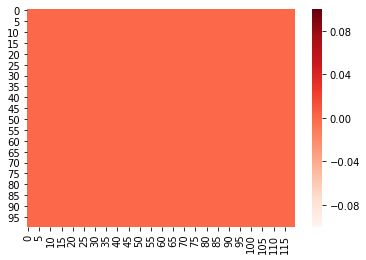

In [82]:
import seaborn as sns
image0 = image0.view(-1, 3, 100, 120)
image0.requires_grad = True

gradients0 = backprop.calculate_gradients(image0, label0)

_ = sns.heatmap(-gradients0.detach().numpy()[0], cmap="Reds")


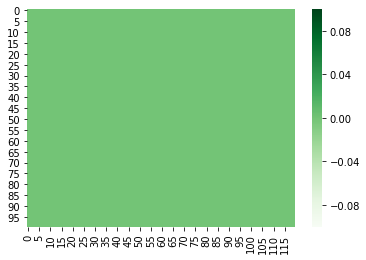

In [83]:
_ = sns.heatmap(-gradients0.detach().numpy()[1], cmap="Greens")

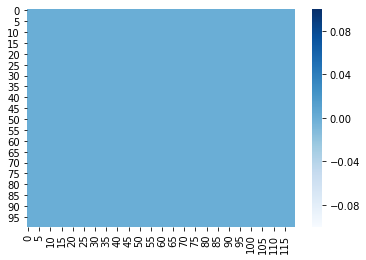

In [84]:
_ = sns.heatmap(-gradients0.detach().numpy()[2], cmap="Blues")


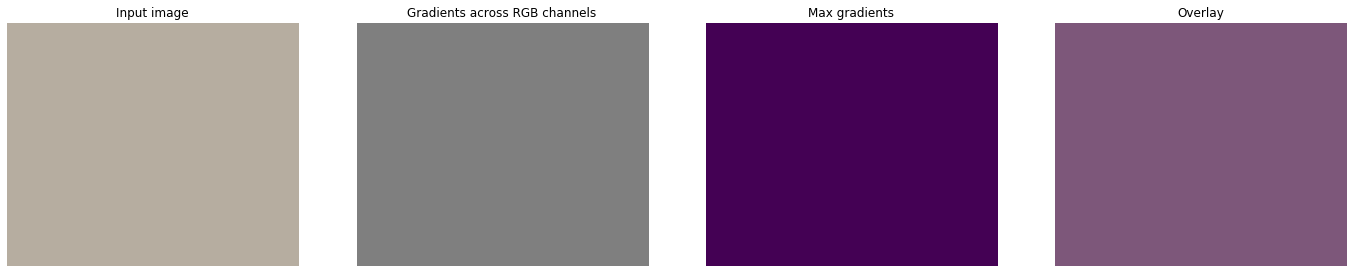

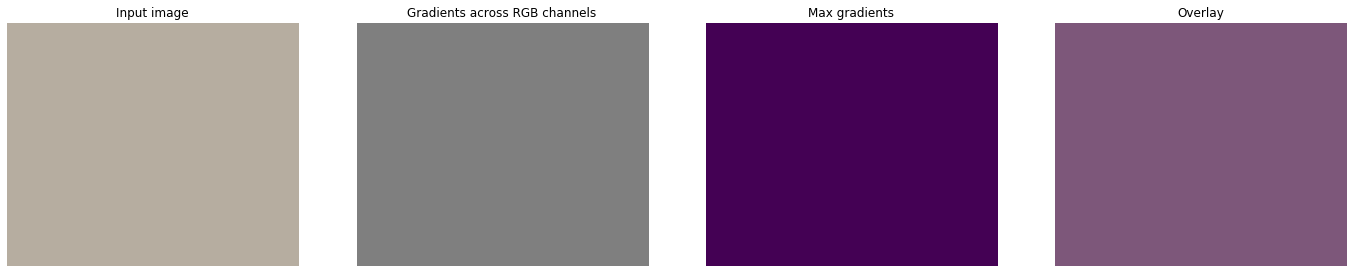

In [85]:
backprop.visualize(image0, label0, guided=False, figsize = (24,20))
backprop.visualize(image0, label0, guided=True, figsize = (24,20))

No particular region of the input is more relevant, since the rule states that the absence of any shape defines this image as a 0. What about an image with label 1 ?

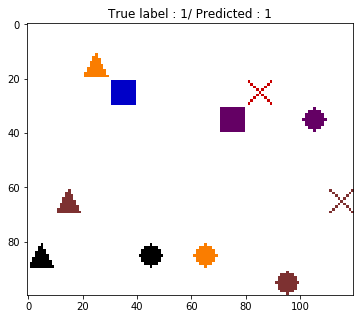

In [86]:
image1 = images[1][0]
label1 = images[1][1]

im1 = image1.view(-1, 3, 100, 120)
outputs = net(im1)
_, predicted1 = torch.max(outputs.data, 1)



display_image(image1, label1, int(predicted1))

This image was correctly labeled as a 1, because it contains a shape.

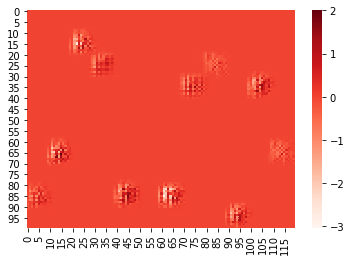

In [87]:
image1 = image1.view(-1, 3, 100, 120)
image1.requires_grad = True

gradients1 = backprop.calculate_gradients(image1, label1)

max_gradients1 = backprop.calculate_gradients(image1, label1, take_max=True)

_ = sns.heatmap(-gradients1.detach().numpy()[0], cmap="Reds")


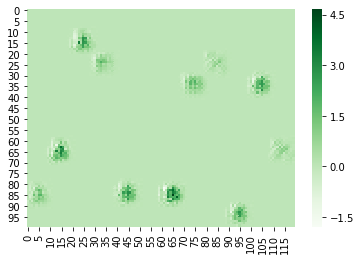

In [88]:
_ = sns.heatmap(-gradients1.detach().numpy()[1], cmap="Greens")


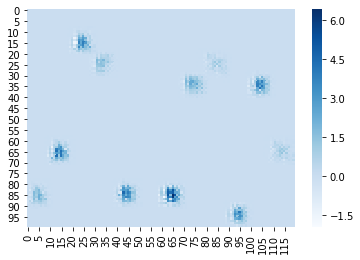

In [89]:
_ = sns.heatmap(-gradients1.detach().numpy()[2], cmap="Blues")


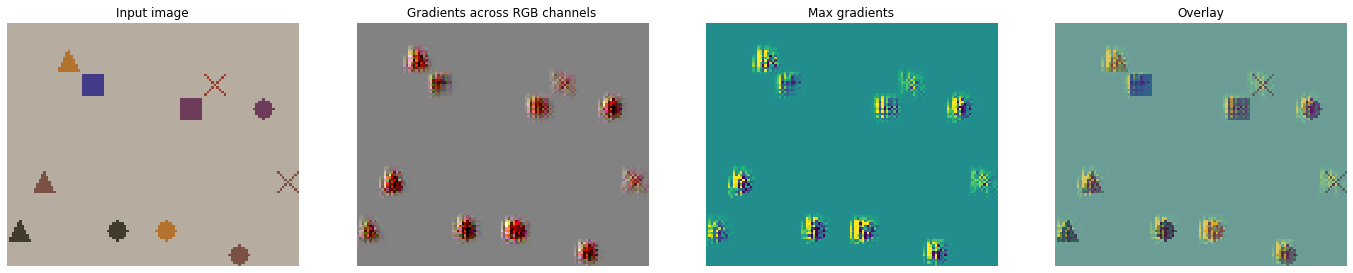

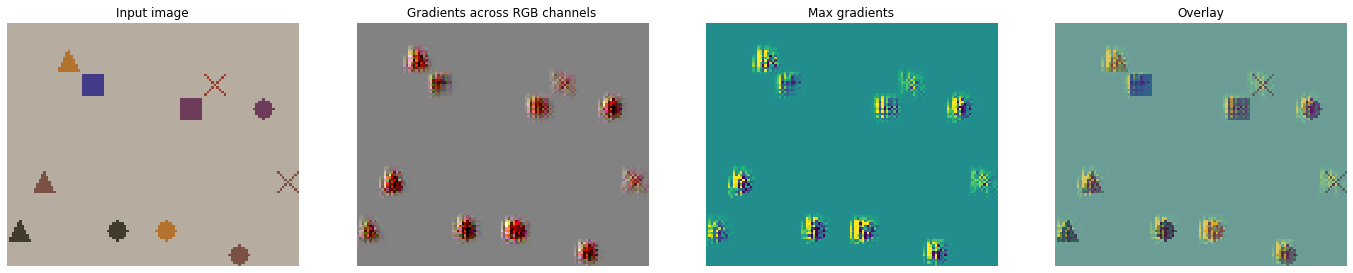

In [90]:
backprop.visualize(image1, label1, guided=False, figsize = (24,20))
backprop.visualize(image1, label1, guided=True, figsize = (24,20))

The model correctly recognizes that the importantt place in the input is where the shapes are. However, there doesn't seem to be an independence between the input channels; all are activated the same, even the spot in the image is only blue for example (we could expect to only see a gradient on the blue channel). This makes some sense since the rule does not place importance on the color, shows a harmless overfitting. 